In [1]:
from dataset_analyzer import MarketAnalyzer
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)
np.set_printoptions(suppress=True)


In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

market = "NASDAQ"
timesteps = 19

train_path = Path(f"/home/mbisoffi/tests/TemporalGNNReview/code/data/datasets/graph/{market}_Train_2016-05-01_2017-06-30_{timesteps}")
val_path = Path(f"/home/mbisoffi/tests/TemporalGNNReview/code/data/datasets/graph/{market}_Validation_2017-07-01_2017-12-31_{timesteps}")
test_path = Path(f"/home/mbisoffi/tests/TemporalGNNReview/code/data/datasets/graph/{market}_Test_2018-01-01_2019-12-31_{timesteps}")

train_analyzer = MarketAnalyzer(train_path)
val_analyzer = MarketAnalyzer(val_path)
test_analyzer = MarketAnalyzer(test_path)



|             Dataset Information             |
| Market Name:         NASDAQ                  |
| Time Period:         Train                   |
| Start Date:          2016-05-01              |
| End Date:            2017-06-30              |
| Window Size:         19                      |
| Normalizer:          None                    |
| Number of Features:  5                       |
| Number of Nodes:     721                     |
| Number of Snapshots: 208                     |
Folder analysis_results already exists at /home/mbisoffi/tests/TemporalGNNReview/code/data/datasets/graph/NASDAQ_Train_2016-05-01_2017-06-30_19
|             Dataset Information             |
| Market Name:         NASDAQ                  |
| Time Period:         Validation              |
| Start Date:          2017-07-01              |
| End Date:            2017-12-31              |
| Window Size:         19                      |
| Normalizer:          None                    |
| Number of Features:  5 

In [3]:
train_snapshots_info = train_analyzer.get_snapshots_info()  
val_snapshots_info = val_analyzer.get_snapshots_info()  
test_snapshots_info = test_analyzer.get_snapshots_info()  


In [4]:
# Unify the dataframes for all datasets

# Convert each dataset's snapshots info to DataFrame and add dataset identifier
train_df = train_analyzer.get_snapshots_info_df()
train_df['dataset'] = 'train'
train_df['dataset_path'] = str(train_path)

val_df = val_analyzer.get_snapshots_info_df()
val_df['dataset'] = 'validation'
val_df['dataset_path'] = str(val_path)

test_df = test_analyzer.get_snapshots_info_df()
test_df['dataset'] = 'test'
test_df['dataset_path'] = str(test_path)

# Combine all datasets into one comprehensive DataFrame
all_snapshots_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Add some useful derived columns
all_snapshots_df['snapshot_id'] = all_snapshots_df.groupby('dataset').cumcount()
all_snapshots_df['total_snapshots'] = all_snapshots_df.groupby('dataset')['snapshot_id'].transform('max') + 1

print(f"Combined DataFrame shape: {all_snapshots_df.shape}")
print(f"Datasets: {all_snapshots_df['dataset'].unique()}")
print(f"Total snapshots per dataset:")
print(all_snapshots_df.groupby('dataset').size())

Combined DataFrame shape: (657, 12)
Datasets: ['train' 'validation' 'test']
Total snapshots per dataset:
dataset
test          371
train         208
validation     78
dtype: int64


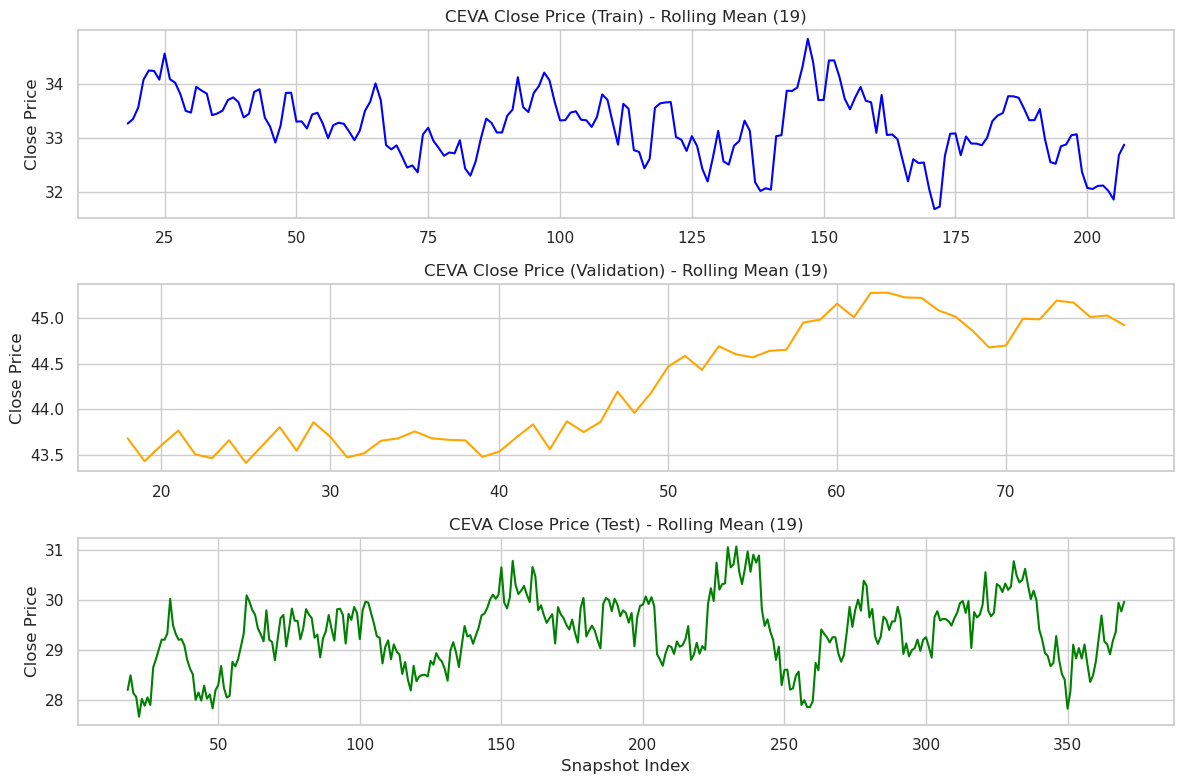

In [5]:
train_node_features = train_analyzer.analyze_node_features()
val_node_features = val_analyzer.analyze_node_features()
test_node_features = test_analyzer.analyze_node_features()
# Style
sns.set_theme(style="whitegrid")

# Set tickers
train_idx = val_idx = test_idx = 100 # Assuming we want to plot the first ticker for all datasets
rolling = timesteps

train_ticker = train_analyzer.index_to_stock[train_idx]
test_ticker = train_analyzer.index_to_stock[test_idx]  # use train_analyzer because both share the same map
val_ticker = train_analyzer.index_to_stock[val_idx]  # use train_analyzer because both share the same map

# Filter data
train_df = train_node_features[train_node_features['ticker'] == train_ticker].sort_values('snapshot_idx')
test_df = test_node_features[test_node_features['ticker'] == test_ticker].sort_values('snapshot_idx')
val_df = val_node_features[val_node_features['ticker'] == val_ticker].sort_values('snapshot_idx')

# Rolling means
train_close = train_df['Close'].rolling(rolling).mean()
test_close = test_df['Close'].rolling(rolling).mean()
val_close = val_df['Close'].rolling(rolling).mean()

# X values
x_train = train_df['snapshot_idx'].values
x_test = test_df['snapshot_idx'].values
x_val = val_df['snapshot_idx'].values

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

# Plot train
axes[0].plot(x_train, train_close, color='blue')
axes[0].set_title(f"{train_ticker} Close Price (Train) - Rolling Mean ({rolling})")
axes[0].set_ylabel("Close Price")

axes[1].plot(x_val, val_close, color='orange')
axes[1].set_title(f"{val_ticker} Close Price (Validation) - Rolling Mean ({rolling})")
axes[1].set_ylabel("Close Price")

# Plot test
axes[2].plot(x_test, test_close, color='green')
axes[2].set_title(f"{test_ticker} Close Price (Test) - Rolling Mean ({rolling})")
axes[2].set_xlabel("Snapshot Index")
axes[2].set_ylabel("Close Price")

plt.tight_layout()
plt.show()


# Adj matrix

In [53]:
adj_matrices = train_analyzer.get_snapshots_adjacency_matrix()

Adjacency matrix shape: (721, 721)


In [62]:
ticker1 = train_analyzer.stock_to_index['NVDA']
ticker2 = train_analyzer.stock_to_index['AAPL']
for adj_matrix_idx in range(100):
    print(f"Adjacency Matrix {adj_matrix_idx}")
    print(f"{train_analyzer.index_to_stock[ticker1]} ->  {adj_matrices[adj_matrix_idx][ticker1, ticker2]:.2f}  -> {train_analyzer.index_to_stock[ticker2]}")
    print(f"{train_analyzer.index_to_stock[ticker1]} <- {adj_matrices[adj_matrix_idx][ticker2, ticker1]:.2f} <- {train_analyzer.index_to_stock[ticker2]}")

Adjacency Matrix 0
NVDA ->  8.02  -> AAPL
NVDA <- 0.00 <- AAPL
Adjacency Matrix 1
NVDA ->  6.45  -> AAPL
NVDA <- 1.23 <- AAPL
Adjacency Matrix 2
NVDA ->  5.77  -> AAPL
NVDA <- 1.94 <- AAPL
Adjacency Matrix 3
NVDA ->  6.44  -> AAPL
NVDA <- 1.25 <- AAPL
Adjacency Matrix 4
NVDA ->  5.74  -> AAPL
NVDA <- 1.95 <- AAPL
Adjacency Matrix 5
NVDA ->  5.16  -> AAPL
NVDA <- 2.50 <- AAPL
Adjacency Matrix 6
NVDA ->  7.76  -> AAPL
NVDA <- 2.50 <- AAPL
Adjacency Matrix 7
NVDA ->  8.16  -> AAPL
NVDA <- 2.50 <- AAPL
Adjacency Matrix 8
NVDA ->  5.07  -> AAPL
NVDA <- 2.60 <- AAPL
Adjacency Matrix 9
NVDA ->  5.72  -> AAPL
NVDA <- 1.97 <- AAPL
Adjacency Matrix 10
NVDA ->  7.93  -> AAPL
NVDA <- 1.97 <- AAPL
Adjacency Matrix 11
NVDA ->  7.47  -> AAPL
NVDA <- 0.17 <- AAPL
Adjacency Matrix 12
NVDA ->  6.94  -> AAPL
NVDA <- 0.69 <- AAPL
Adjacency Matrix 13
NVDA ->  6.97  -> AAPL
NVDA <- 0.69 <- AAPL
Adjacency Matrix 14
NVDA ->  7.53  -> AAPL
NVDA <- 0.19 <- AAPL
Adjacency Matrix 15
NVDA ->  7.56  -> AAPL
NVDA <-

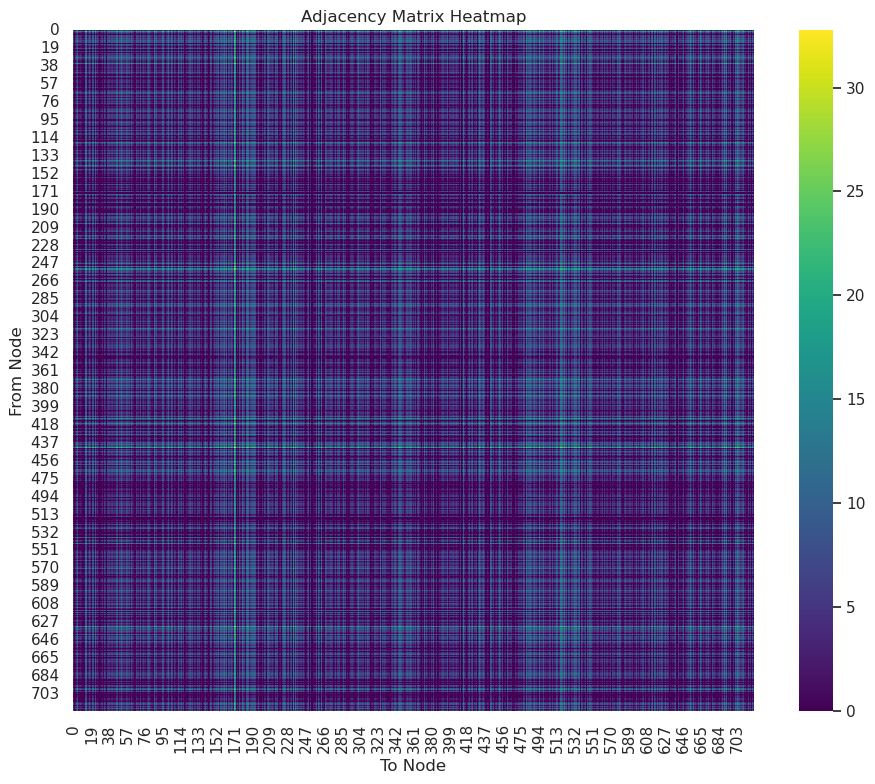

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrices[0], cmap="viridis", square=True)
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("To Node")
plt.ylabel("From Node")
plt.tight_layout()
plt.show()


# Test feature analyzer

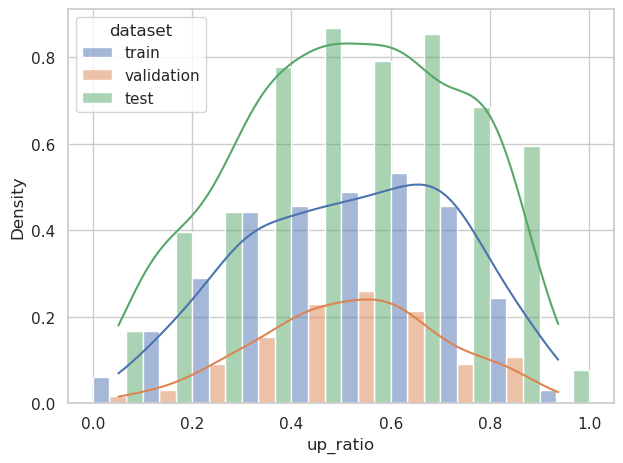

In [9]:
sns.histplot(
    data=all_snapshots_df, 
    x='up_ratio', 
    hue='dataset',
    multiple='dodge',
    binrange=(0, 1), 
    binwidth=0.1,
    stat='density',
    kde=True,
)
plt.tight_layout()
plt.show()


<Axes: xlabel='up_ratio', ylabel='Count'>

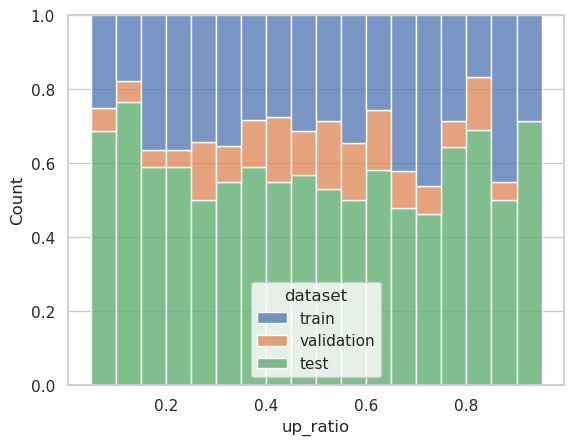

In [10]:
sns.histplot(data=all_snapshots_df, x='up_ratio', 
             hue='dataset',
             multiple='fill',
            binrange=(0, 1), 
            binwidth=.05,
            )

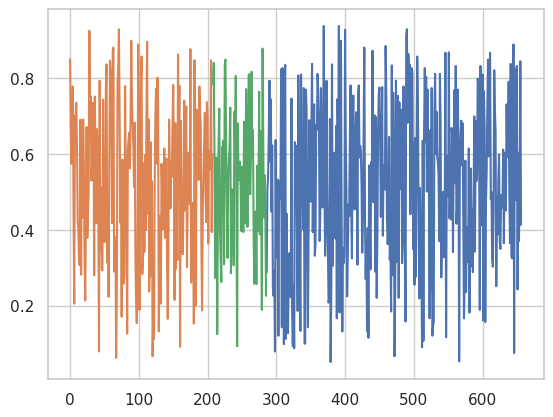

In [11]:
all_snapshots_df['up_ratio'].groupby(all_snapshots_df['dataset']).plot();

In [12]:
all_snapshots_df[ all_snapshots_df['dataset'] == 'train' ][ ['up_ratio', 'connectivity'] ].describe()

,up_ratio,connectivity
count,208.000000,208.000000
mean,0.523552,0.758894
std,0.209490,0.005263
min,0.062413,0.748033
25%,0.353675,0.755005
50%,0.531900,0.758148
75%,0.691054,0.761988
max,0.929265,0.771879


In [13]:
# Display the combined DataFrame
print("First few rows of the combined DataFrame:")
print(all_snapshots_df.head())

print("\nDataFrame columns:")
print(all_snapshots_df.columns.tolist())

print("\nDataFrame info:")
print(all_snapshots_df.info())

# Display basic statistics
print("\nBasic statistics by dataset:")
print(all_snapshots_df.groupby('dataset').describe())

First few rows of the combined DataFrame:
   snapshot_index  num_nodes  num_edges  up_target  down_target  up_ratio  \
0               0        721     400609        613          108  0.850208   
1               1        721     393997        472          249  0.654646   
2               2        721     396007        414          307  0.574202   
3               3        721     392983        514          207  0.712899   
4               4        721     389836        561          160  0.778086   

   down_ratio  connectivity dataset  \
0    0.149792      0.771708   train   
1    0.345354      0.758971   train   
2    0.425798      0.762843   train   
3    0.287101      0.757018   train   
4    0.221914      0.750955   train   

                                        dataset_path  snapshot_id  \
0  /home/mbisoffi/tests/TemporalGNNReview/code/da...            0   
1  /home/mbisoffi/tests/TemporalGNNReview/code/da...            1   
2  /home/mbisoffi/tests/TemporalGNNReview/code/da... 

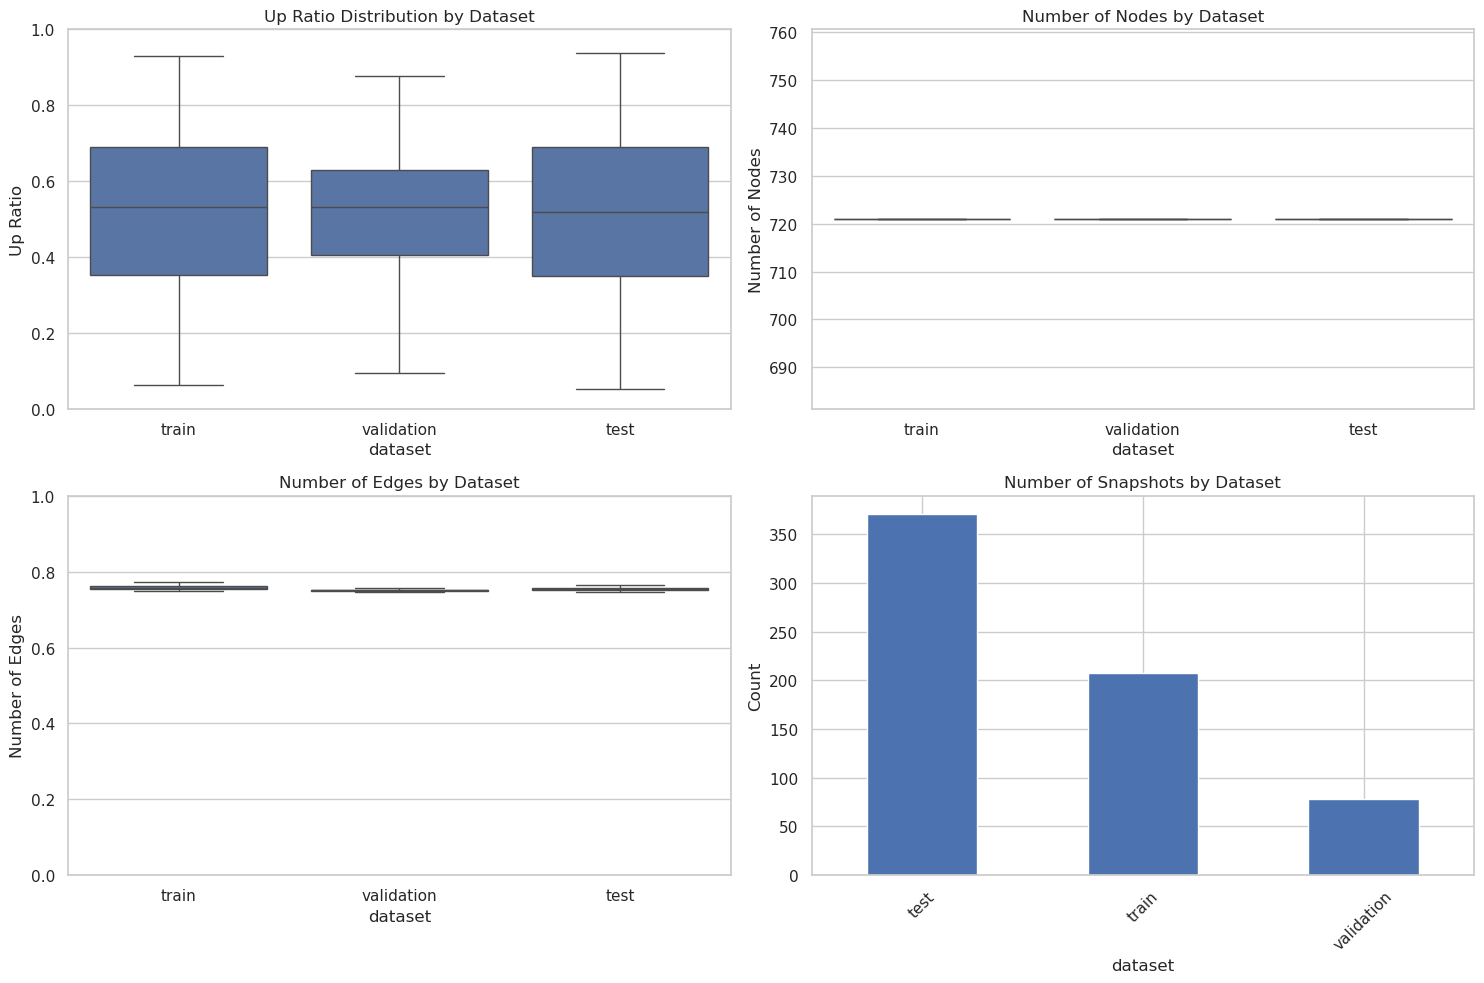

In [14]:
# Visualize key metrics across datasets
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Up ratio distribution by dataset
if 'up_ratio' in all_snapshots_df.columns:
    sns.boxplot(data=all_snapshots_df, x='dataset', y='up_ratio', ax=axes[0, 0])
    axes[0, 0].set_title('Up Ratio Distribution by Dataset')
    axes[0, 0].set_ylabel('Up Ratio')
    axes[0,0].set_ylim(0, 1)

# Plot 2: Number of nodes by dataset
if 'num_nodes' in all_snapshots_df.columns:
    sns.boxplot(data=all_snapshots_df, x='dataset', y='num_nodes', ax=axes[0, 1])
    axes[0, 1].set_title('Number of Nodes by Dataset')
    axes[0, 1].set_ylabel('Number of Nodes')

# Plot 3: Connectivity by dataset
if 'connectivity' in all_snapshots_df.columns:
    sns.boxplot(data=all_snapshots_df, x='dataset', y='connectivity', ax=axes[1, 0])
    axes[1, 0].set_title('Number of Edges by Dataset')
    axes[1, 0].set_ylabel('Number of Edges')
    axes[1, 0].set_ylim(0,1)  # Log scale for better visibility

# Plot 4: Snapshot counts by dataset
dataset_counts = all_snapshots_df['dataset'].value_counts()
dataset_counts.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Number of Snapshots by Dataset')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

# Up ratios analysis 

In [15]:
# Use the comprehensive DataFrame created above
df = all_snapshots_df.copy()

# Display basic info about the combined DataFrame
print(f"Total snapshots across all datasets: {len(df)}")
print(f"Datasets included: {df['dataset'].unique()}")
print(f"Date ranges covered:")
for dataset in df['dataset'].unique():
    subset = df[df['dataset'] == dataset]
    print(f"  {dataset}: {len(subset)} snapshots")

Total snapshots across all datasets: 657
Datasets included: ['train' 'validation' 'test']
Date ranges covered:
  train: 208 snapshots
  validation: 78 snapshots
  test: 371 snapshots
